## Vamos entender cada parte do "Masked Multi-Head Attention"

### Motivação

O embeddings da camada anterior são estáticos, ou seja, seu valor independe do contexto no qual o token está inserido.

Idealmente, seria interessante alterar o valor do embedding de uma palavra com base nas palavras adjascentes.

### Exemplo:
"Joana não atravessou a estrada porque ela"

<div style="text-align: center;">
    <img src="figures/attention.png" alt="Atenção" width="50%"/>
</div>

In [414]:
import torch
import torch.nn.functional as F
from torch import nn

### Contextualizando embeddings do token "ela"

In [415]:
X = torch.tensor([[1., 0., 0., 0., 0., 0., 0.],    # "Joana"
                  [0., 1., 0., 0., 0., 0., 0.],    # "não"
                  [0., 0., 1., 0., 0., 0., 0.],    # "atravessou"
                  [0., 0., 0., 1., 0., 0., 0.],    # "a"
                  [0., 0., 0., 0., 1., 0., 0.],    # "estrada"
                  [0., 0., 0., 0., 0., 1., 0.],    # "porque"
                  [0., 0., 0., 0., 0., 0., 1.]],    # "ela"
).float()

embedding_ela_contextualizado = 0.3 * X[0] + 0.3 * X[4] + 0.4* X[6]
embedding_ela_contextualizado

tensor([0.3000, 0.0000, 0.0000, 0.0000, 0.3000, 0.0000, 0.4000])

### Generalizando: matrix de atenção

In [416]:
attention = torch.tensor([
                [1., 0., 0., 0., 0., 0., 0.], 
                [0., 1., 0., 0., 0., 0., 0.],
                [0., 0., 1., 0., 0., 0., 0.],
                [0., 0., 0., 1., 0., 0., 0.],
                [0., 0., 0., 0., 1., 0., 0.], 
                [0., 0., 0., 0., 0., 1., 0.],
                [0.3, 0., 0., 0., 0.3, 0., 0.4],    # mapa de atenção para a palavra "ela"
]).float()


print(f'Depois da atenção: \n')
print((attention.matmul(X)).numpy())

Depois da atenção: 

[[1.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0. ]
 [0.3 0.  0.  0.  0.3 0.  0.4]]


### Primeira parte "Attention"

### Scaled Dot-Product

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

### Query, Keys e Values: intuição

### Entendendo melhor a equação:
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

#### O produto $QK^T$ é uma medida de similaridade entre a query e keys.

A multiplicação matricial $QK^T$ pode ser decomposta em vários produtos escalares:

$$
\vec{q_i} \cdot \vec{k_i} = \|\vec{q_i}\| \|\vec{k_i}\| \cos(\theta)
$$

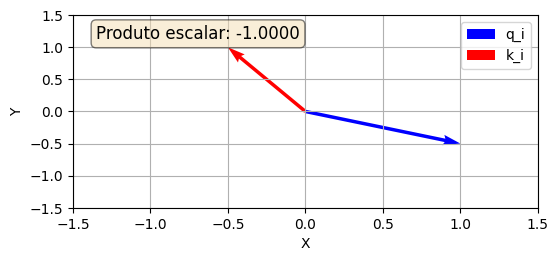

In [417]:
from utils import plot_tensors_2d

q_i = torch.tensor([1, -0.5]).float()
k_i = torch.tensor([-0.5, 1]).float()
plot_tensors_2d(q_i, k_i, q_i @ k_i)

### Função softmax

$$S(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

In [418]:
qK = torch.tensor([1.0, 2.0, -1.0])
probabilidades = F.softmax(qK, dim=0)
print(f"Scores antes do Softmax: {qK.numpy()}")
print(f"Porcentagens de atenção (após Softmax): {[f'{p:.5f}' for p in probabilidades]}\n")

Scores antes do Softmax: [ 1.  2. -1.]
Porcentagens de atenção (após Softmax): ['0.25950', '0.70538', '0.03512']



Dividimos o vetor de simularidade $QK^T$ por $\sqrt{d_k}$ para evitar saturação da função softmax.


In [419]:
qK = torch.tensor([5.0, 10.0, -5.0])
probabilidades = F.softmax(qK, dim=0)
print(f"Scores antes do Softmax: {qK.numpy()}")
print(f"Porcentagens de atenção (após Softmax): {[f'{p:.5f}' for p in probabilidades]}\n")

Scores antes do Softmax: [ 5. 10. -5.]
Porcentagens de atenção (após Softmax): ['0.00669', '0.99331', '0.00000']



### Implementação da função de atenção

In [420]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.scale = torch.sqrt(torch.FloatTensor([d_model]))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        Q, K, V = self.fc_q(x), self.fc_k(x), self.fc_v(x)
        qK = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attention = torch.softmax(qK, dim=-1)
        return attention, torch.matmul(self.dropout(attention), V)

In [421]:
BATCH_SIZE = 1 # "Olá Mundo!
SEQUENCE_LENGTH = 3 # 3 palavras
EMBEDDING_DIM = 3 # dimensão do embedding

att_layer = ScaledDotProductAttention(d_model=EMBEDDING_DIM, dropout=0.1)

X = torch.randn(BATCH_SIZE, SEQUENCE_LENGTH, EMBEDDING_DIM)
attention_map, scaled_values = att_layer(X)

print(f'Mapa de Atenção:\n{attention_map.detach().numpy()}\n')
print(f'Valores escalados:\n{scaled_values.detach().numpy()}\n')

Mapa de Atenção:
[[[0.30517125 0.3518007  0.34302798]
  [0.34265134 0.31043655 0.34691215]
  [0.32037795 0.31516412 0.36445796]]]

Valores escalados:
[[[0.09005516 0.6183486  0.00632677]
  [0.05684423 0.6182948  0.03358088]
  [0.07641272 0.6058252  0.02379057]]]



## "Masked": evitando valores futuros

In [422]:
mask = torch.tril(torch.ones(EMBEDDING_DIM, EMBEDDING_DIM))
mask

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [423]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.scale = torch.sqrt(torch.FloatTensor([d_model]))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        Q, K, V = self.fc_q(x), self.fc_k(x), self.fc_v(x)
        qK = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            # Substituimos valores iguais a zero na máscara por um número negativo muito grande
            qK = qK.masked_fill(mask == 0, -1e10)
        # Desta forma, a função softmax se encarrega zerar a atenção nos tokens futuros
        attention = torch.softmax(qK, dim=-1) # e^-1000000000 ~ 0
        return attention, torch.matmul(self.dropout(attention), V)

In [424]:
BATCH_SIZE = 1
SEQUENCE_LENGTH = 3
EMBEDDING_DIM = 3

att_layer = ScaledDotProductAttention(d_model=EMBEDDING_DIM, dropout=0.1)

X = torch.randn(BATCH_SIZE, SEQUENCE_LENGTH, EMBEDDING_DIM)
attention_map, scaled_values = att_layer(X, mask=mask)

print(f'Mapa de Atenção:\n{attention_map.detach().numpy()}\n')

Mapa de Atenção:
[[[1.         0.         0.        ]
  [0.4973726  0.5026274  0.        ]
  [0.33138165 0.2751819  0.3934365 ]]]



## "Multi-Head"

<div style="text-align: center;">
    <img src="figures/mha.png" alt="Multi-Head Attention" width="50%"/>
</div>

In [425]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.fc_q = nn.Linear(d_model, n_heads)
        self.fc_k = nn.Linear(d_model, n_heads)
        self.fc_v = nn.Linear(d_model, n_heads)
        self.scale = torch.sqrt(torch.FloatTensor([n_heads]))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        Q, K, V = self.fc_q(x), self.fc_k(x), self.fc_v(x)
        qK = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            # Substituimos valores iguais a zero na máscara por um número negativo muito grande
            qK = qK.masked_fill(mask == 0, -1e10)
        # Desta forma, a função softmax se encarrega zerar a atenção nos tokens futuros
        attention = torch.softmax(qK, dim=-1) # e^-1000000000 ~ 0
        return attention, torch.matmul(self.dropout(attention), V)


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()

        assert d_model % n_heads == 0

        self.heads = nn.ModuleList([
            ScaledDotProductAttention(d_model, d_model // n_heads, dropout)
            for _ in range(n_heads)
        ])

        self.linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        head_outputs = [head(x, mask) for head in self.heads]
        attention_maps = [out[0] for out in head_outputs]
        scaled_values = [out[1] for out in head_outputs]

        concatenated = torch.cat(scaled_values, dim=-1)
        return attention_maps, self.linear(concatenated)

In [426]:
mha = MultiHeadAttention(d_model=EMBEDDING_DIM, n_heads=3, dropout=0.1)
attention_maps, values = mha(X, mask=mask)
attention_maps

[tensor([[[1.0000, 0.0000, 0.0000],
          [0.3275, 0.6725, 0.0000],
          [0.4764, 0.3105, 0.2131]]], grad_fn=<SoftmaxBackward0>),
 tensor([[[1.0000, 0.0000, 0.0000],
          [0.7450, 0.2550, 0.0000],
          [0.3432, 0.3275, 0.3293]]], grad_fn=<SoftmaxBackward0>),
 tensor([[[1.0000, 0.0000, 0.0000],
          [0.5674, 0.4326, 0.0000],
          [0.1468, 0.3911, 0.4621]]], grad_fn=<SoftmaxBackward0>)]

In [427]:
values

tensor([[[ 0.2705, -1.3190, -0.3792],
         [ 0.2559, -1.0529, -0.4411],
         [ 0.2173, -0.6071, -0.2119]]], grad_fn=<ViewBackward0>)